In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2018()

In [3]:
Ms = 32
F = model.param.F.value
ne = 4
nS8 = 8
nS4 = 4

param = model.default_parameter_values
param.process_model(model)

S8_discharge_initial = param["Initial Condition for S8 ion [g]"]
S4_discharge_initial = param["Initial Condition for S4 ion [g]"]

capacity = F*ne*((3*S8_discharge_initial/nS8)+(S4_discharge_initial/nS4))/(3600*Ms)
capacity

3.387539707400625

In [4]:
param

{'Active reaction area per cell [m2]': 0.96,
 'Ambient Temperature [K]': 298.0,
 'Apparent Geometric Area [m2]': 0.29,
 'Bruggeman Constant [-]': 6.0,
 'Cell Thickness [m]': 4e-05,
 'Cell heat capacity [J.g-1.K-1]': 2.0,
 'Cell heat transfer coefficient [W.K-1]': 0.2,
 'Cell mass [kg]': 0.129,
 'Conductivity Relation Slope [S.m2.mol]': 4.6e-07,
 'Current function [A]': 1.0,
 'Density of precipitated Sulfur [g.L-1]': 2000.0,
 'Electrolyte volume per cell [L]': 0.0114,
 'Electron number per reaction [electrons]': 4.0,
 'Exchange current density H [A.m-2]': 10.0,
 'Exchange current density L [A.m-2]': 5.0,
 'Initial Cell Porosity [-]': 0.65,
 'Initial Condition for Precipitated Sulfur [g]': 2.7000000000000004e-06,
 'Initial Condition for S ion [g]': 8.830728523107219e-10,
 'Initial Condition for S2 ion [g]': 0.002697299116926997,
 'Initial Condition for S4 ion [g]': 0.0027,
 'Initial Condition for S8 ion [g]': 2.6946000000000003,
 'Initial Condition for Shuttled Sulfur [g]': 0.0,
 'Initia

In [5]:
current = 1.7
hours = 4
time_in_seconds = hours*3600
# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for S8 ion [g]": 2.6730,
        "Initial Condition for S4 ion [g]": 0.0128,
        "Initial Condition for S2 ion [g]": 4.3321e-6,
        "Initial Condition for S ion [g]": 1.6321e-6,
        "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
        "Initial Condition for Terminal Voltage [V]": 2.4,
        "Shuttle rate coefficient during charge [s-1]": 0.0002,
        # "Shuttle rate coefficient during discharge [s-1]": 1e-10,
        "Shuttle rate coefficient during discharge [s-1]": 0.0,
        "Initial Condition for Terminal Voltage [V]" : 2.4
    }
)
params.process_model(model)
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15
    ),
)
sim.solve(np.linspace(0, time_in_seconds, 10000))
voltage = sim.solution['Terminal voltage [V]'].entries
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

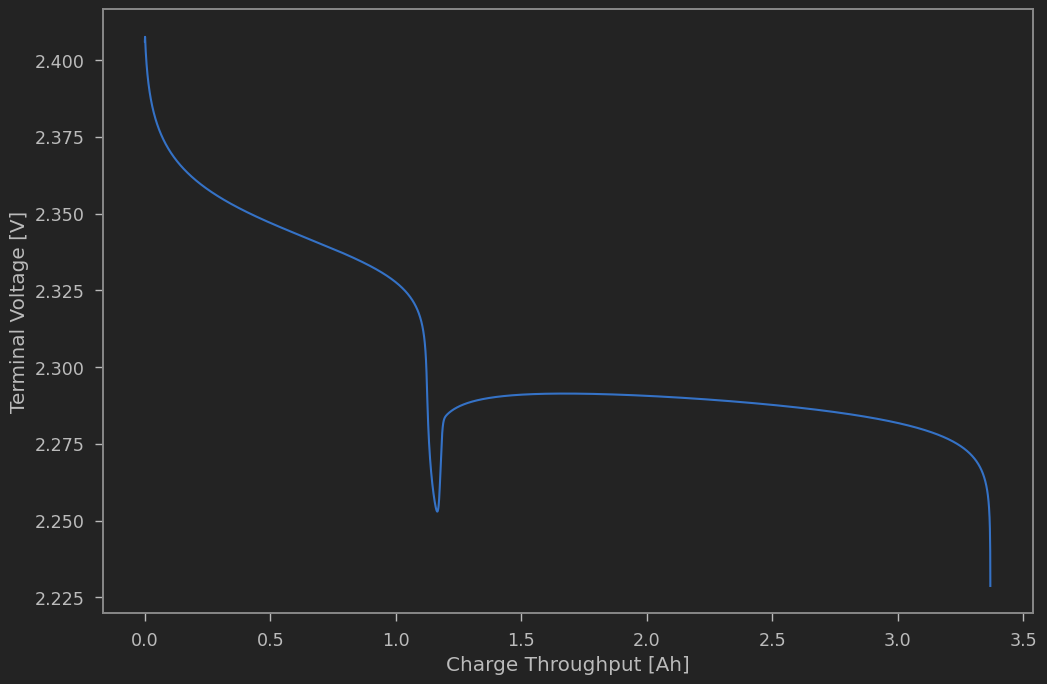

In [6]:
plt.plot(abs(current)*sim.solution.t/3600, voltage)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

In [12]:
def marinsecu2018_discharge(current,ppt):
    model = pybamm.lithium_sulfur.MarinescuEtAl2018()
    hours = 4
    time_in_seconds = hours*3600
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": current,
            'Precipitation rate [s-1]':ppt,
            "Initial Condition for S8 ion [g]": 2.6730,
            "Initial Condition for S4 ion [g]": 0.0128,
            "Initial Condition for S2 ion [g]": 4.3321e-6,
            "Initial Condition for S ion [g]": 1.6321e-6,
            "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
            "Initial Condition for Terminal Voltage [V]": 2.4,
            "Shuttle rate coefficient during charge [s-1]": 0.0002,
            # "Shuttle rate coefficient during discharge [s-1]": 1e-10,
            "Shuttle rate coefficient during discharge [s-1]": 0.0,
            "Initial Condition for Terminal Voltage [V]" : 2.4
        }
    )
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 20
        ),
    )
    steps = 1000
    unresolved = True
    while unresolved:
        try:
            if steps > 1e6:
                return none
                break
            sim.solve(np.linspace(0, time_in_seconds, steps))
            unresolved = False
        except:
            steps *= 10
    return sim


    

In [13]:
sim_1_7_ppt_yes = marinsecu2016_discharge(1.7,100.0)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 7134.06 and h = 8.46657e-14, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...

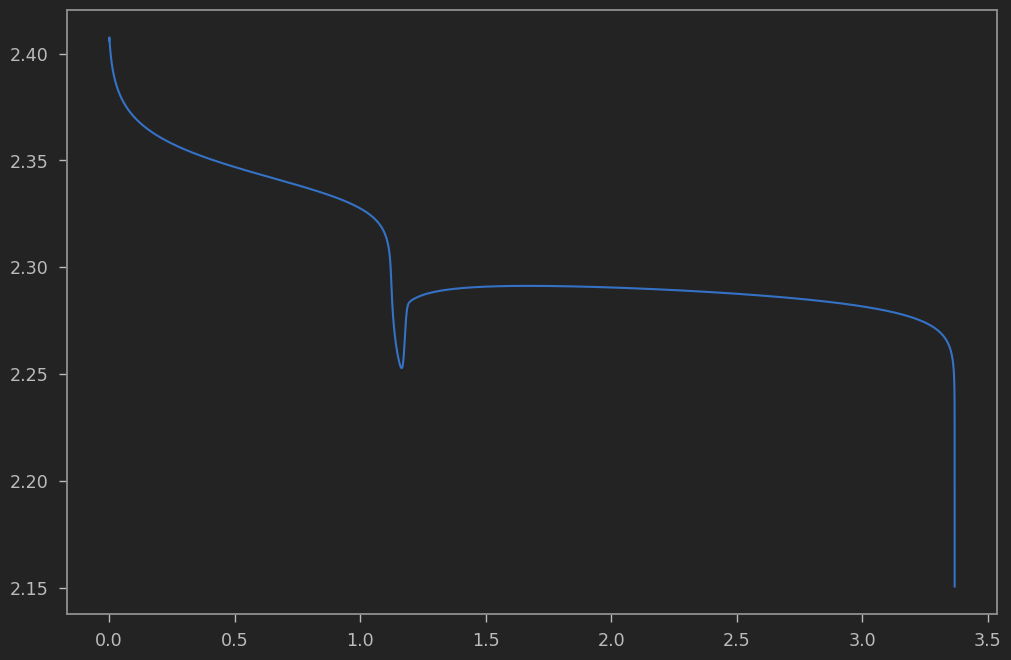

In [14]:
voltage_1_7_ppt_yes = sim_1_7_ppt_yes.solution['Terminal voltage [V]'].entries
Ah_1_7_ppt_yes = abs(1.7)*sim_1_7_ppt_yes.solution.t/3600
plt.plot(Ah_1_7_ppt_yes, voltage_1_7_ppt_yes)

In [16]:
experiment = pybamm.Experiment(["Discharge at 1.1 A for 3 hours",
                                "Charge at 1.1 A for 4 hours"])
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    experiment = experiment
)
solver=pybamm.CasadiSolver(
    atol=1e-6, 
    rtol=1e-3, 
    extra_options_setup={"max_step_size": 0.1},
    max_step_decrease_count = 15
)
sim.solve()

At t = 25076.3 and h = 8.84632e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 25075.1 and h = 1.11859e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 25075.2 and h = 2.04687e-11, the corrector convergence failed repeatedly or with |h| = hmin.


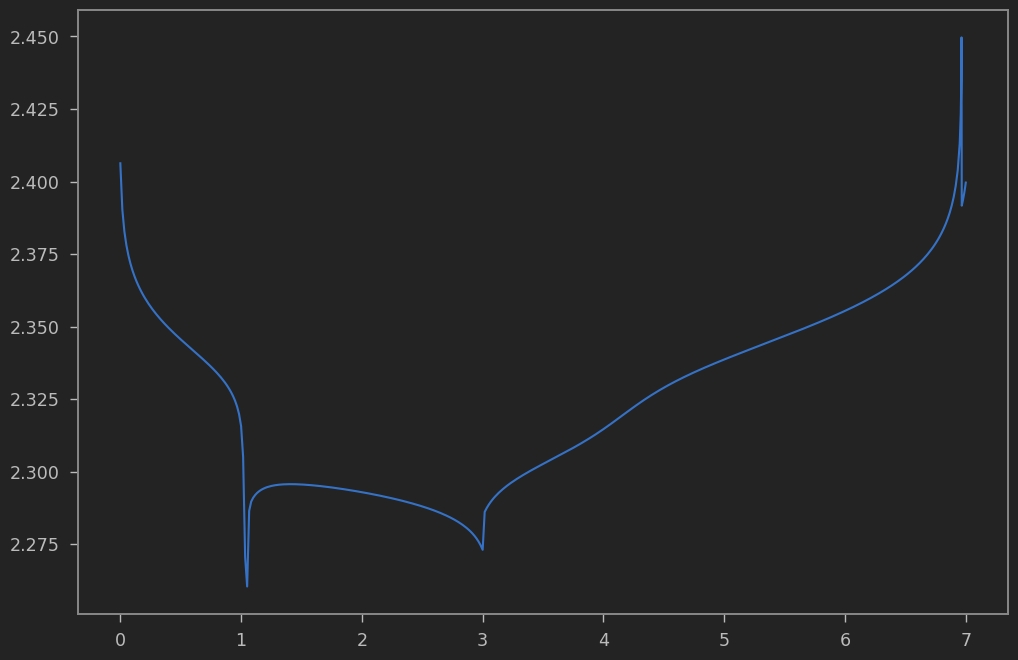

In [17]:
voltage = sim.solution['Terminal voltage [V]'].entries
Ah = abs(1.1)*sim.solution.t/3600
time = sim.solution.t/3600
plt.plot(time, voltage)

In [22]:
experiment = pybamm.Experiment(["Discharge at 1.1 A until 2.3 V",
                                "Charge at 1.1 A for 4 hours"])
sim = pybamm.Simulation(
    model,
    parameter_values=params,
    experiment = experiment
)
solver=pybamm.CasadiSolver(mode = 'safe',
    atol=1e-6, 
    rtol=1e-3, 
    extra_options_setup={"max_step_size": 0.1},
    max_step_decrease_count = 15
)
sim.solve()

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 10973.2 and h

SolverError: Maximum number of decreased steps occurred at t=11017.875000000002. Try solving the model up to this time only or reducing dt_max (currently, dt_max=0.23671875).

In [21]:
voltage = sim.solution['Terminal voltage [V]'].entries
Ah = abs(1.1)*sim.solution.t/3600
time = sim.solution.t/3600
plt.plot(time, voltage)

TypeError: 'NoneType' object is not subscriptable

In [140]:
sim_1_7_ppt_no = marinsecu2016_discharge(1.7,0.0)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 6947.86 and h

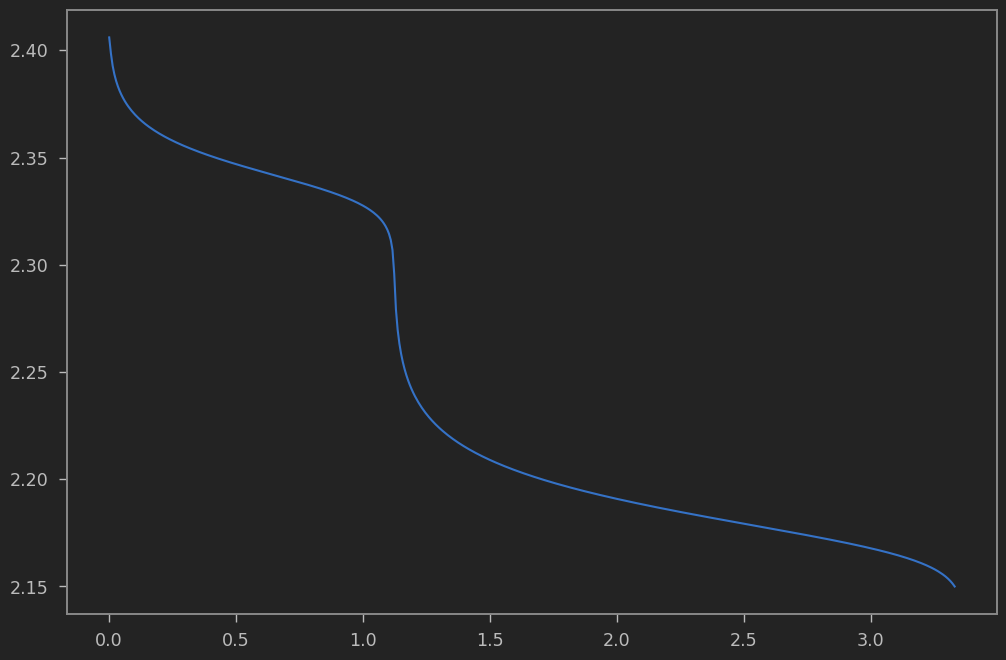

In [141]:
voltage_1_7_ppt_no = sim_1_7_ppt_no.solution['Terminal voltage [V]'].entries
Ah_1_7_ppt_no = abs(1.7)*sim_1_7_ppt_no.solution.t/3600
plt.plot(Ah_1_7_ppt_no, voltage_1_7_ppt_no)

In [149]:
sim_6_8_ppt_no = marinsecu2016_discharge(6.8, 0.0)

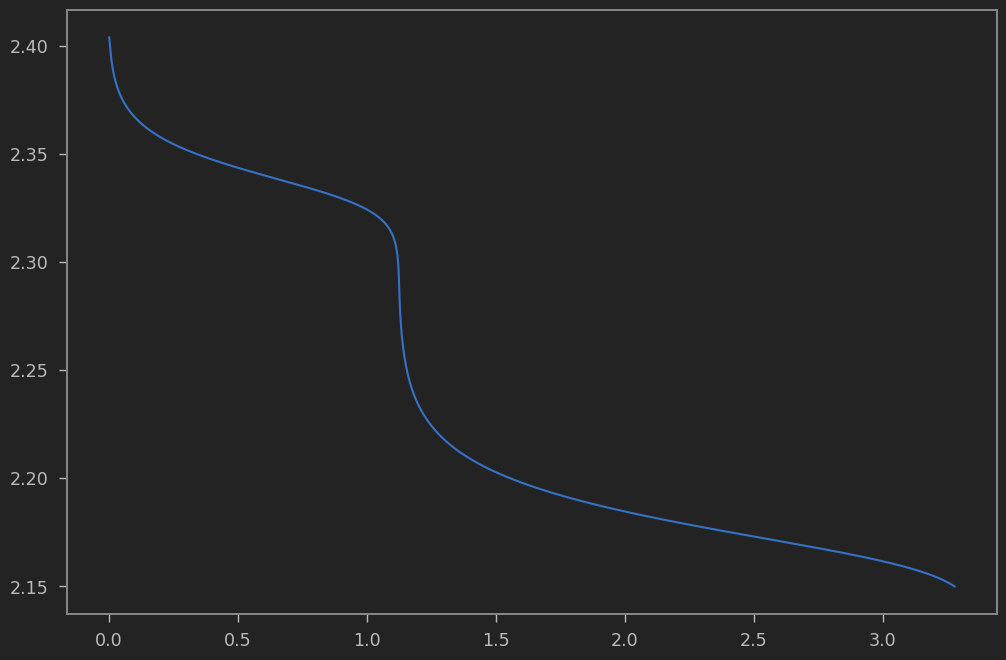

In [150]:
voltage_6_8_ppt_no = sim_6_8_ppt_no.solution['Terminal voltage [V]'].entries
Ah_6_8_ppt_no = abs(6.8)*sim_6_8_ppt_no.solution.t/3600
plt.plot(Ah_6_8_ppt_no, voltage_6_8_ppt_no)

In [ ]:
sim_6_8_ppt_yes = marinsecu2016_discharge(6.8,100.0)

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [ ]:
voltage_6_8_ppt_yes = sim_6_8_ppt_yes.solution['Terminal voltage [V]'].entries
Ah_6_8_ppt_yes = abs(6.8)*sim_6_8_ppt_yes.solution.t/3600
plt.plot(Ah_6_8_ppt_yes, voltage_6_8_ppt_yes)

In [135]:
voltage_1_7_ppt_yes = sim_1_7_ppt_yes.solution['Terminal voltage [V]'].entries
Ah_1_7_ppt_yes = abs(1.7)*sim_1_7_ppt_yes.solution.t/3600
voltage_1_7_ppt_no = sim_1_7_ppt_no.solution['Terminal voltage [V]'].entries
Ah_1_7_ppt_no = abs(1.7)*sim_1_7_ppt_no.solution.t/3600
voltage_6_8_ppt_yes = sim_6_8_ppt_yes.solution['Terminal voltage [V]'].entries
Ah_6_8_ppt_yes = abs(6.8)*sim_6_8_ppt_yes.solution.t/3600
voltage_6_8_ppt_no = sim_6_8_ppt_no.solution['Terminal voltage [V]'].entries
Ah_6_8_ppt_no = abs(6.8)*sim_6_8_ppt_no.solution.t/3600


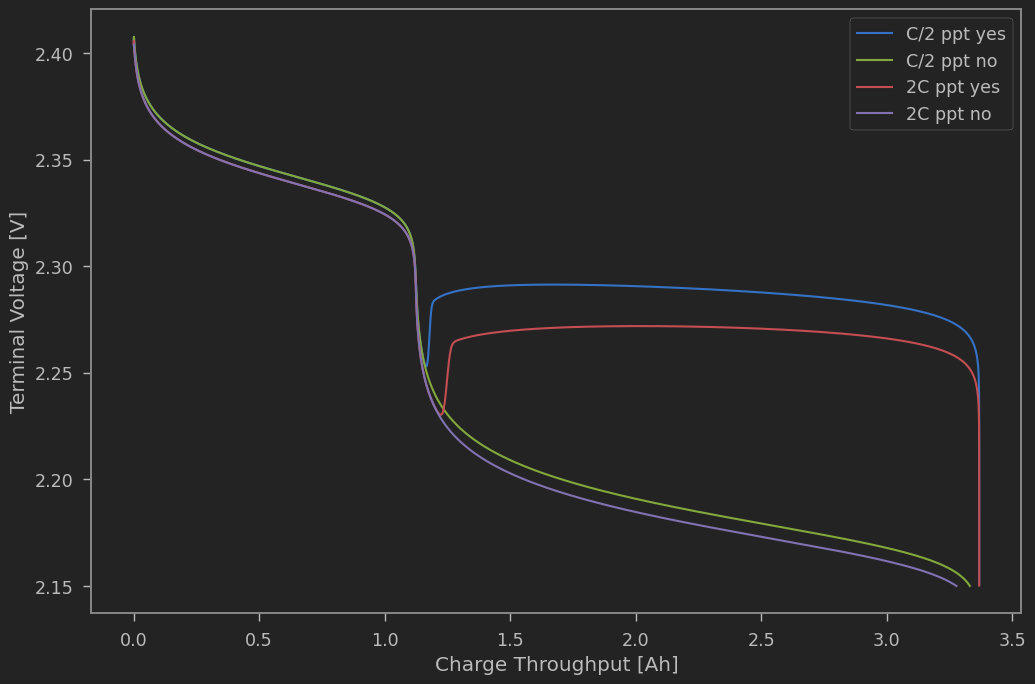

In [136]:
plt.plot(Ah_1_7_ppt_yes, voltage_1_7_ppt_yes)
plt.plot(Ah_1_7_ppt_no, voltage_1_7_ppt_no)
plt.plot(Ah_6_8_ppt_yes, voltage_6_8_ppt_yes)
plt.plot(Ah_6_8_ppt_no, voltage_6_8_ppt_no)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]")
plt.legend(["C/2 ppt yes","C/2 ppt no","2C ppt yes","2C ppt no"]);

In [111]:
def marinsecu2016_charge(current,ppt, ic):
    S8_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial = ic
    model = pybamm.lithium_sulfur.MarinescuEtAl2016()
    hours = 4
    time_in_seconds = hours*3600
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": current,
            'Precipitation rate [s-1]':ppt,
            "Initial Condition for S8 ion [g]":  S8_initial,
            "Initial Condition for S4 ion [g]": S4_initial,
            "Initial Condition for S2 ion [g]": S2_initial,
            "Initial Condition for S ion [g]": S_initial,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            "Shuttle rate coefficient during charge [s-1]": 0.0002,
        }
    )
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15
        ),
    )
    sim.solve(np.linspace(0, time_in_seconds, 1000))
    
    return sim

In [37]:
def ic_grab(sim):
    ref = -10
    S8_initial = sim.solution["S8 [g]"].entries[ref]
    S4_initial = sim.solution["S4 [g]"].entries[ref]
    S2_initial = sim.solution["S2 [g]"].entries[ref]
    S_initial = sim.solution["S [g]"].entries[ref]
    Sp_initial = sim.solution["Precipitated Sulfur [g]"].entries[ref]
    V_initial = sim.solution["Terminal voltage [V]"].entries[ref]
    return (S8_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial )

In [113]:
ic_1_7_ppt_yes = ic_grab(sim_1_7_ppt_yes)
ic_1_7_ppt_no = ic_grab(sim_1_7_ppt_no)
ic_6_8_ppt_yes = ic_grab(sim_6_8_ppt_yes)
ic_6_8_ppt_no = ic_grab(sim_6_8_ppt_no)

In [114]:
ch_sim_1_7_ppt_no = marinsecu2016_charge(-1.5,0.0,ic_1_7_ppt_no)
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

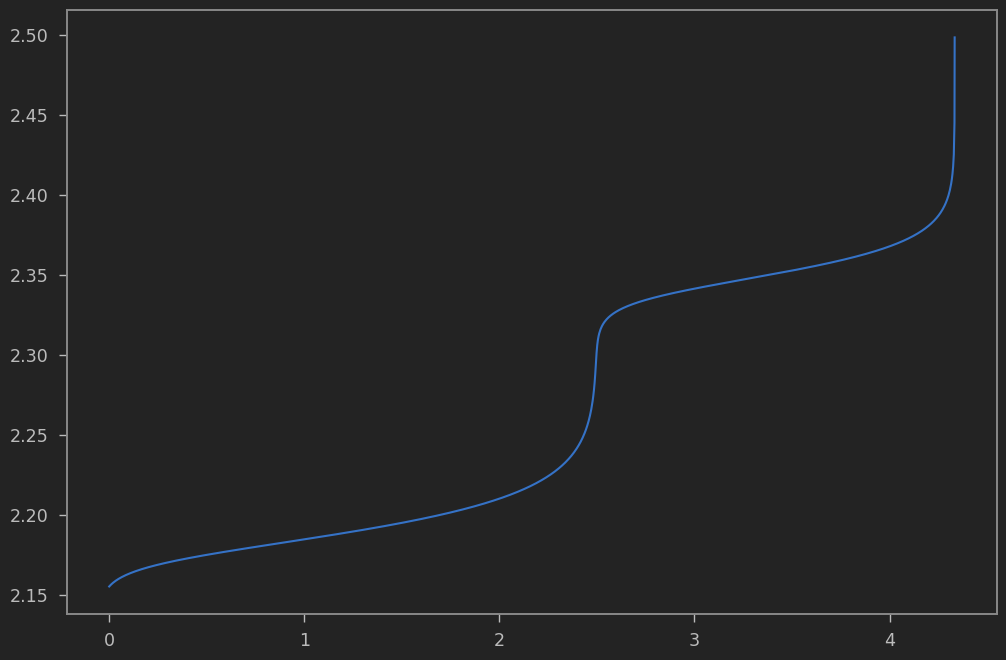

In [115]:
ch_voltage_1_7_ppt_no = ch_sim_1_7_ppt_no.solution['Terminal voltage [V]'].entries
ch_Ah_1_7_ppt_no = abs(1.7)*ch_sim_1_7_ppt_no.solution.t/3600
plt.plot(ch_Ah_1_7_ppt_no, ch_voltage_1_7_ppt_no)

In [116]:
# start the charge from same current but allow ppt effects
ch_sim_1_7_ppt_no = marinsecu2016_charge(-1.7,0.0,ic_1_7_ppt_no)
ch_sim_1_7_ppt_yes = marinsecu2016_charge(-1.7,100.0,ic_1_7_ppt_yes)
ch_sim_6_8_ppt_no = marinsecu2016_charge(-3.4, 0.0,ic_1_7_ppt_no)
ch_sim_6_8_ppt_yes = marinsecu2016_charge(-3.4, 100.0,ic_1_7_ppt_yes)
notify

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 7895.2 and h = 4.19095e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2521.92 and h = 9.74563e-09, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2521.73 and h = 2.54979e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 2521.93 and h = 3.85414e-09, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 2521.94 and h = 4.65661e-11, the corrector convergence failed repeatedly or with |h| = hmin.
psetup faile

In [117]:
ch_voltage_1_7_ppt_yes = ch_sim_1_7_ppt_yes.solution['Terminal voltage [V]'].entries
ch_Ah_1_7_ppt_yes = abs(1.7)*ch_sim_1_7_ppt_yes.solution.t/3600
ch_voltage_1_7_ppt_no = ch_sim_1_7_ppt_no.solution['Terminal voltage [V]'].entries
ch_Ah_1_7_ppt_no = abs(1.7)*ch_sim_1_7_ppt_no.solution.t/3600
ch_voltage_6_8_ppt_yes = ch_sim_6_8_ppt_yes.solution['Terminal voltage [V]'].entries
ch_Ah_6_8_ppt_yes = abs(3.4)*ch_sim_6_8_ppt_yes.solution.t/3600
ch_voltage_6_8_ppt_no = ch_sim_6_8_ppt_no.solution['Terminal voltage [V]'].entries
ch_Ah_6_8_ppt_no = abs(3.4)*ch_sim_6_8_ppt_no.solution.t/3600

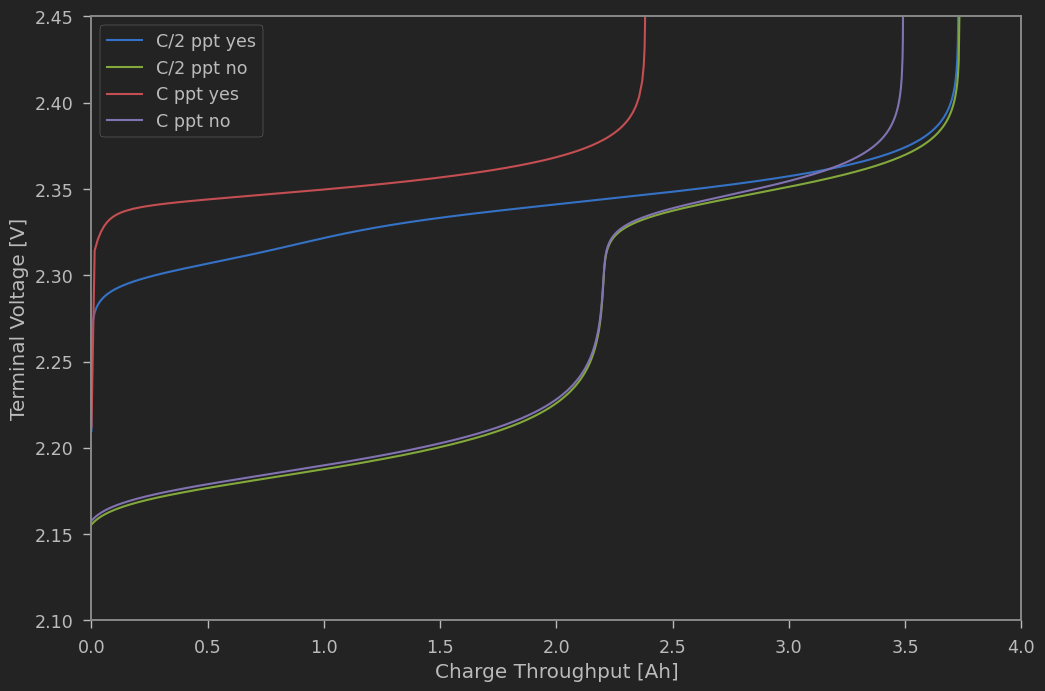

In [118]:
ref = -1
plt.plot(ch_Ah_1_7_ppt_yes[:ref], ch_voltage_1_7_ppt_yes[:ref])
plt.plot(ch_Ah_1_7_ppt_no[:ref], ch_voltage_1_7_ppt_no[:ref])
plt.plot(ch_Ah_6_8_ppt_yes[:ref], ch_voltage_6_8_ppt_yes[:ref])
plt.plot(ch_Ah_6_8_ppt_no[:ref], ch_voltage_6_8_ppt_no[:ref])
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]")
plt.xlim(0,4)
plt.ylim(2.1,2.45)
plt.legend(["C/2 ppt yes","C/2 ppt no","C ppt yes","C ppt no"]);

In [32]:
def marinsecu2016_discharge(S_star,ppt):
    model = pybamm.lithium_sulfur.MarinescuEtAl2016()
    hours = 4
    time_in_seconds = hours*3600
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": 1.7,
            'Precipitation rate [s-1]':ppt,
            "Initial Condition for S8 ion [g]": 2.6730,
            "Initial Condition for S4 ion [g]": 0.0128,
            "Initial Condition for S2 ion [g]": 4.3321e-6,
            "Initial Condition for S ion [g]": 1.6321e-6,
            "Initial Condition for Precipitated Sulfur [g]": 2.7e-06,
            "Initial Condition for Terminal Voltage [V]": 2.4,
            "Shuttle rate coefficient during charge [s-1]": 0.0002,
            # "Shuttle rate coefficient during discharge [s-1]": 1e-10,
            "Shuttle rate coefficient during discharge [s-1]": 0.0,
            "Initial Condition for Terminal Voltage [V]" : 2.4,
            "S saturation mass [g]": S_star
        }
    )
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 20
        ),
    )
    steps = 10000
    unresolved = True
    while unresolved:
        try:
            if steps > 1e6:
                return none
                break
            print('\n')
            print('\n')
            print('\n')
            print('Working on ppt = {} and S_star = {} with steps = {}'.format(ppt,S_star,steps))
            print('\n')
            print('\n')
            print('\n')
            sim.solve(np.linspace(0, time_in_seconds, steps))
            unresolved = False
        except:
            steps *= 10
    return sim

In [33]:
ppt_array = [100,500]
S_star_array = [0.0001,0.0050]
sim_array = []

for ppt in ppt_array:
    for S_star in S_star_array:
        sim = marinsecu2016_discharge(S_star,ppt)
        sim_array.append([sim,ppt,S_star])
        







Working on ppt = 100 and S_star = 0.0001 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c







Working on ppt = 100 and S_star = 0.005 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c







Working on ppt = 500 and S_star = 0.0001 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 7134.06 and h = 6.61451e-16, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: ...







Working on ppt = 500 and S_star = 0.005 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


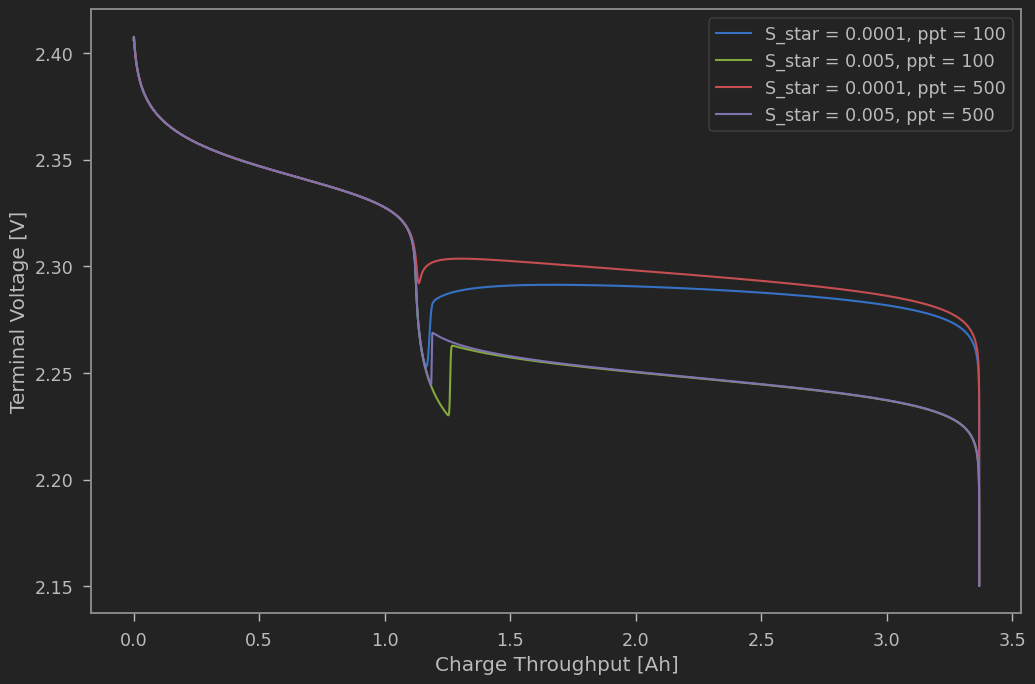

In [34]:
legend = []
i = 0 
for i in range(0,4):
    sim = sim_array[i][0]
    voltage = sim.solution['Terminal voltage [V]'].entries
    Ah = abs(1.7)*sim.solution.t/3600
    plt.plot(Ah,voltage)
    legend.append("S_star = {}, ppt = {}".format(sim_array[i][2],sim_array[i][1]))
plt.legend(legend)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

In [39]:
def marinsecu2016_charge(S_star,ppt,ic):
    S8_initial, S4_initial, S2_initial, S_initial, Sp_initial, V_initial = ic
    model = pybamm.lithium_sulfur.MarinescuEtAl2016()
    hours = 4
    time_in_seconds = hours*3600
    params = model.default_parameter_values
    params.update(
        {
            "Current function [A]": -1.7,
            'Precipitation rate [s-1]':ppt,
            "Initial Condition for S8 ion [g]":  S8_initial,
            "Initial Condition for S4 ion [g]": S4_initial,
            "Initial Condition for S2 ion [g]": S2_initial,
            "Initial Condition for S ion [g]": S_initial,
            "Initial Condition for Precipitated Sulfur [g]": Sp_initial,
            "Initial Condition for Terminal Voltage [V]": V_initial,
            "Shuttle rate coefficient during charge [s-1]": 0.0002,
            # "Shuttle rate coefficient during discharge [s-1]": 1e-10,
            "Shuttle rate coefficient during discharge [s-1]": 0.0,
            "Initial Condition for Terminal Voltage [V]" : 2.4,
            "S saturation mass [g]": S_star
        }
    )
    sim = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15
        ),
    )
    steps = 10000
    unresolved = True
    while unresolved:
        try:
            if steps > 1e6:
                return none
                break
            print('\n')
            print('\n')
            print('\n')
            print('Working on ppt = {} and S_star = {} with steps = {}'.format(ppt,S_star,steps))
            print('\n')
            print('\n')
            print('\n')
            sim.solve(np.linspace(0, time_in_seconds, steps))
            unresolved = False
        except:
            steps *= 10
    return sim

In [48]:
i = 0
sim = sim_array[i][0]
ppt = sim_array[i][1]
S_star = sim_array[i][2]
ic = ic_grab(sim)

In [41]:
charge_array = []
i = 0
sim = sim_array[i][0]
ppt = sim_array[i][1]
S_star = sim_array[i][2]
ic = ic_grab(sim)
ch_sim = marinsecu2016_charge(S_star,ppt,ic)
charge_array.append([ch_sim, ppt, S_star])








Working on ppt = 100 and S_star = 0.0001 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

In [49]:
charge_array = []
i = 1
sim = sim_array[i][0]
ppt = sim_array[i][1]
S_star = sim_array[i][2]
ch_sim = marinsecu2016_charge(S_star,ppt,ic)
charge_array.append([ch_sim, ppt, S_star])







Working on ppt = 100 and S_star = 0.005 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 8340.34 and h = 2.41977e-12, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 8340.34 and

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c







Working on ppt = 100 and S_star = 0.005 with steps = 100000








res failed: KeyboardInterrupt
At t = 76.1791, the residual function failed unrecoverably.








Working on ppt = 100 and S_star = 0.005 with steps = 1000000








KeyboardInterrupt: 

In [42]:
i = 2
sim = sim_array[i][0]
ppt = sim_array[i][1]
S_star = sim_array[i][2]
ic = ic_grab(sim)
ch_sim = marinsecu2016_charge(S_star,ppt,ic)
charge_array.append([ch_sim, ppt, S_star])







Working on ppt = 500 and S_star = 0.0001 with steps = 10000








At t = 8067.68 and h = 3.32627e-09, the corrector convergence failed repeatedly or with |h| = hmin.


In [ ]:
i = 3
sim = sim_array[i][0]
ppt = sim_array[i][1]
S_star = sim_array[i][2]
ch_sim = marinsecu2016_charge(S_star,ppt,ic)
charge_array.append([ch_sim, ppt, S_star])







Working on ppt = 500 and S_star = 0.005 with steps = 10000








psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 8222.35 and h

In [ ]:
legend = []
i = 0 
for i in range(0,4):
    ch_sim = charge_array[i][0]
    voltage = ch_sim.solution['Terminal voltage [V]'].entries
    Ah = abs(1.7)*ch_sim.solution.t/3600
    plt.plot(Ah,voltage)
    legend.append("S_star = {}, ppt = {}".format(ch_sim_array[i][2],ch_sim_array[i][1]))
plt.legend(legend)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

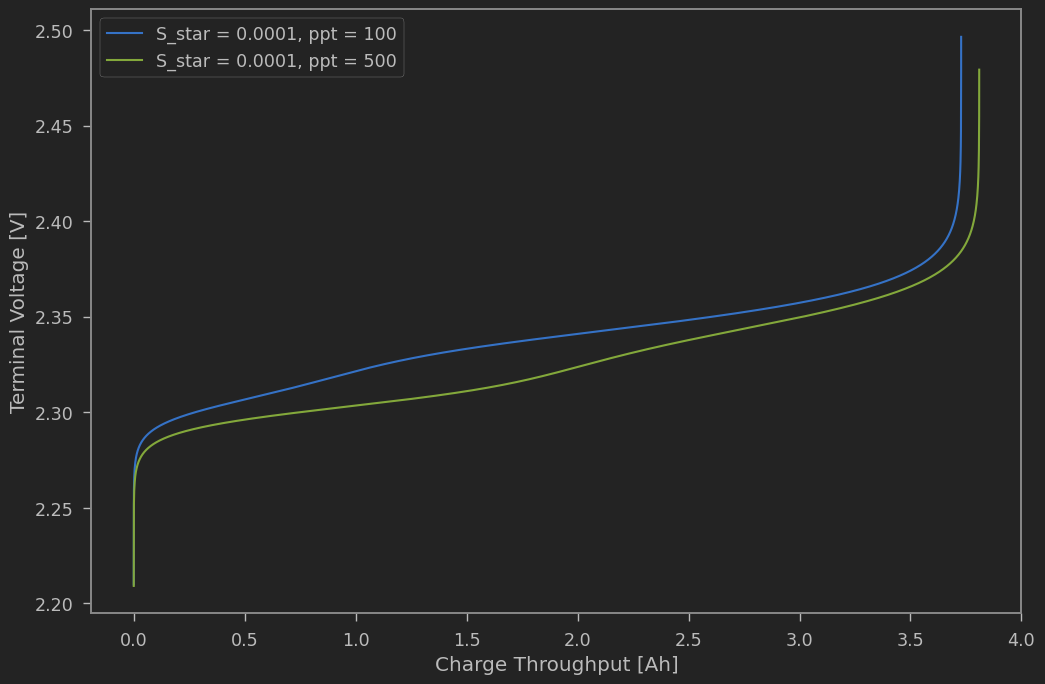

In [47]:
legend = []
i = 0 
for i in range(0,2):
    ch_sim = charge_array[i][0]
    ppt = charge_array[i][1]
    S_star = charge_array[i][2]
    voltage = ch_sim.solution['Terminal voltage [V]'].entries
    Ah = abs(1.7)*ch_sim.solution.t/3600
    plt.plot(Ah,voltage)
    legend.append("S_star = {}, ppt = {}".format(S_star,ppt))
plt.legend(legend)
plt.xlabel("Charge Throughput [Ah]")
plt.ylabel("Terminal Voltage [V]");

In [45]:
charge_array

[[<pybamm.simulation.Simulation at 0x7f5d2009cbb0>, 100, 0.0001],
 [<pybamm.simulation.Simulation at 0x7f5d12a9ed60>, 500, 0.0001]]